In [ ]:
#Contribution Function plot
#Yingjie Zhu @PKU Dec 10, 2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import ticker
from matplotlib import rcParams
from helita.sim import rh15d
import os
import xarray as xr
import scipy.io
from scipy.integrate.quadrature import cumtrapz
from scipy.interpolate import interp1d
import astropy.constants as const
from astropy import units as u
from helita.utils.utilsmath import planck, voigt
import h5py
from decimal import Decimal
rcParams['text.usetex'] = True
rcParams['text.latex.unicode'] = True

def sci_not(x):
    x = np.format_float_scientific(x,unique=False,precision=2)
    dec_x = Decimal(x)
    t = dec_x.as_tuple()
    #print(t)
    sig = str(t.digits[0])+'.'+ str(t.digits[1]) + str(t.digits[2])
    exp = str(t.exponent + 2)
    return sig,exp

#read RH 1.5D output & Atmosphere input
data = rh15d.Rh15dout("/Users/yjzhu/Desktop/Solar/Num/rh15d_mg/rh15d/5F11_pt1s_nb_300_CII_SB_112/output")
data_atmos = h5py.File('/Users/yjzhu/Desktop/Solar/Num/rh15d_mg/Atmos/Kowalski2017/5F11_complete_nb_pt1s_sp.hdf5','r')

--- Read /Users/yjzhu/Desktop/Solar/Num/rh15d_mg/rh15d/5F11_pt1s_nb_300_CII_SB_112/output/output_aux.hdf5 file.
--- Read /Users/yjzhu/Desktop/Solar/Num/rh15d_mg/rh15d/5F11_pt1s_nb_300_CII_SB_112/output/output_indata.hdf5 file.
--- Read /Users/yjzhu/Desktop/Solar/Num/rh15d_mg/rh15d/5F11_pt1s_nb_300_CII_SB_112/output/output_ray.hdf5 file.


/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/Users/yjzhu/.local/lib/python3.7/site-packages/helita-0.9.0-py3.7-macosx-10.9-x86_64.egg/helita/sim/rh15d.py:40: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in xarray v0.12. If necessary, you can control the maximum number of simultaneous open files with xarray.set_options(file_cache_maxsize=...).
  setattr(self, g, xr.open_dataset(infile, group=g, autoclose=True))
/Users/yjzhu/.local/lib/python3.7/site-packages/helita-0.9.0-py3.7-macosx-10.9-x86_64.egg/helita/sim/rh15d.py:53: FutureWarning: The autoclose argument is no longer used by xarray.open_dataset() and is now ignored; it will be removed in xarray v0.12. If necessary, you can control the maximum number of simu

In [41]:


tindex = 0
#snapshot index(in atmosphere input file)
tindex_aux = 112
#ray angle (cosine)
mu = 0.77
#height interval
height_interval = [0.7413,0.725]
height_points = np.linspace(height_interval[0],height_interval[1],100000)
#select plus wavelength in nm
wvl_plus = 0.007
#wavelength interval
wvl_wing = 0.03
#height_retention
height_ret = 10
#if plot density
plot_density = False
#speed of light in Km/s
c = const.c.to('km/s').value
#line core wavelength for plot
#lc_wvl = 1.e7/(71491.062-35669.312) + wvl_plus # 2791
#lc_wvl = 1.e7/35760.875 + wvl_plus #Mg II k
lc_wvl = 133.5708 + wvl_plus #Mg II h

#wavelength points in different units for plotting & interpolation
wvl_points0 = np.linspace(lc_wvl - wvl_wing,lc_wvl + wvl_wing,500)
wvl_pointsv = (wvl_points0/lc_wvl - 1)*c
wvl_pointsa = (wvl_points0 - lc_wvl) * 10
#line + continuum intensity
intensity = data.ray.intensity[tindex,0]
intensity = intensity.loc[lc_wvl - wvl_wing:lc_wvl + wvl_wing]
#intensity = intensity.interp(wavelength = wvl_points0)
#atmosphere parameters, height & temperature (dropna because of the corona cut off)
height_out = data.atmos.height_scale[tindex,0].dropna('height')/1e6
height_t_index = len(height_out)
#the height from RH1.5D outputs sometimes suffers from rounding errors
height = data_atmos['z'].value/1e6
height = np.array(height[0,tindex_aux,0,-height_t_index:])
temperature = data.atmos.temperature[tindex,0].dropna('height')
temperature.coords['height'] = height
#temperature_sel = temperature.where(temperature < 1e5,drop = True)
#temperature_sel = temperature_sel.loc[:0.5]
electron_density = data_atmos['electron_density'].value/1e6
electron_density = xr.DataArray(electron_density[0,tindex_aux,0,-height_t_index:],coords = [('height',height)]) 
if plot_density:
    density = scipy.io.readsav('/Volumes/yjzhu/radyn/idl/tx.sol.max5F11_d4_Ec25_Qel20s-tb09hm88.pt1s.COMPLETE.idl')['d1t']
    density = density[tindex_aux,-height_t_index:]

#electron_density_sel = electron_density.interp(height = temperature_sel.coords['height'])
#source function
sf_all = data.ray.source_function.isel(x = tindex,y = 0)
sf_drop = sf_all.dropna('height')
sf_sel = sf_drop.sel(wavelength_selected = slice(lc_wvl - wvl_wing,lc_wvl + wvl_wing))
sf_sel.coords['height'] = height
#interpolate the data to plot
sf_lc = sf_sel.sel(wavelength_selected = lc_wvl,method = 'nearest')
#Planck function at line center(stationary wavelength)
bplanck = np.array([])
bplanck = [planck(lc_wvl * u.nm,temperature_ * u.K,dist='frequency').value for temperature_ in temperature.values]
#Opacity \chi
chi_all = data.ray.chi.isel(x = tindex,y = 0)
chi_drop = chi_all.dropna('height')
chi_sel = chi_drop.sel(wavelength_selected = slice(lc_wvl - wvl_wing,lc_wvl + wvl_wing))
chi_sel.coords['height'] = height
#Optical depth \tau, integrate from \chi
tau = chi_sel[1:,:]
for i in range(len(chi_sel.coords['wavelength_selected'])):
    tau[:,i] = cumtrapz(chi_sel[:, i],x=-height*1e6)
#interpolate the data to plot
#calculate the other 3 panels
tau_exp_tau = tau * np.exp(-tau/mu)
chi_tau = chi_sel[1:,:]/tau
ctbfun = sf_sel[1:,:] * tau_exp_tau * chi_tau
ctbfun_sel = ctbfun.interp(wavelength_selected = lc_wvl)
ctbfun_pri = cumtrapz(ctbfun_sel,x = ctbfun_sel.coords['height'])
ctbfun_pri = ctbfun_pri/ctbfun_pri[-1]
ctbfun_pri = 1 - ctbfun_pri
height_cpri = interp1d(ctbfun_pri,ctbfun_sel.coords['height'][1:])([0.1,0.9])
ctbfun_plot = ctbfun.interp(height = height_points)
ctbfun_plot = ctbfun_plot.interp(wavelength_selected = wvl_points0)
ctbfun_plot = np.sqrt(ctbfun_plot)
delta_z = (height_cpri[1] -height_cpri[0])*1e3 #delta Z in km
sig_dz,exp_dz = sci_not(delta_z)
#velocity_z in km/s
velocity_z = data.atmos.velocity_z[tindex,0].dropna('height')/1e3
velocity_z.coords['height'] = height
velocity_z_sel = velocity_z.sel(height = slice(height_interval[0],height_interval[1]))
velocity_z_sel = velocity_z_sel.where(velocity_z_sel < 0,drop = True)

#Weighted average

electron_density_sel = electron_density.interp(height = np.linspace(height_cpri[1],height_cpri[0],1000))
ctbfun_sel_ne = ctbfun_sel.interp(height = electron_density_sel.coords['height'])
electron_density_aver = cumtrapz(electron_density_sel*ctbfun_sel_ne,x = -electron_density_sel.coords['height'])[-1]/cumtrapz(ctbfun_sel_ne,x = -electron_density_sel.coords['height'])[-1]
sig_eda, exp_eda = sci_not(electron_density_aver)

temperature_sel = temperature.interp(height = np.linspace(height_cpri[1],height_cpri[0],1000))
ctbfun_sel_temp = ctbfun_sel.interp(height = temperature_sel.coords['height'])
temperature_aver = cumtrapz(temperature_sel*ctbfun_sel_temp,x = -temperature_sel.coords['height'])[-1]/cumtrapz(ctbfun_sel_temp,x = -temperature_sel.coords['height'])[-1]
sig_ta, exp_ta = sci_not(temperature_aver)

ctbfun_sel_vz = ctbfun_sel.interp(height = velocity_z_sel.coords['height'])
ctbfun_sel_vz = ctbfun_sel_vz[1:]
velocity_z_sel = velocity_z_sel[1:]
velocity_z_aver = cumtrapz(velocity_z_sel*ctbfun_sel_vz,x = -velocity_z_sel.coords['height'])[-1]/cumtrapz(ctbfun_sel_vz,x = -velocity_z_sel.coords['height'])[-1]


/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


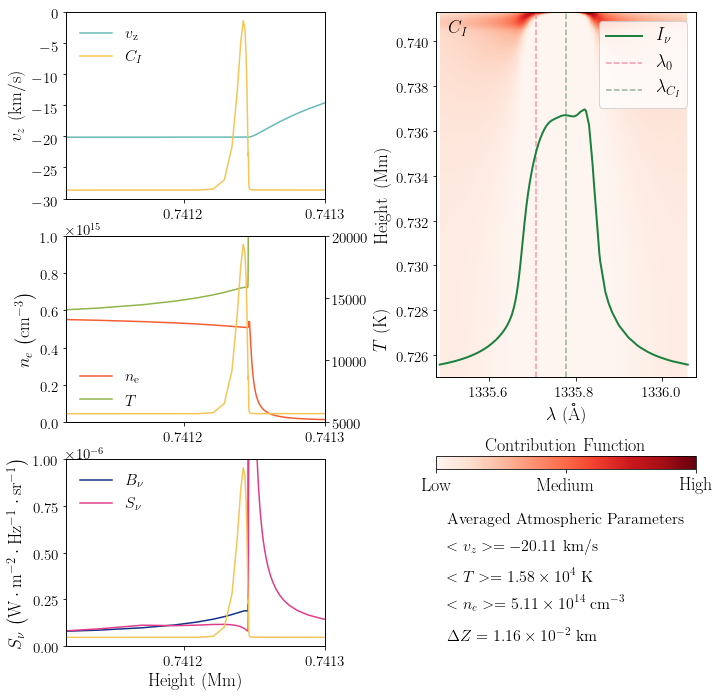

In [42]:
#plot a figure of distribution of contribution function distribution with 
#electron density, temperature and velocity z

fig, ax = plt.subplots(figsize = (10,10))
ax11 = plt.subplot2grid((6,4),(0,0),rowspan = 2,colspan = 2)
ax12 = plt.subplot2grid((6,4),(2,0),rowspan = 2,colspan = 2)
ax15 = plt.subplot2grid((6,4),(4,0),rowspan = 2,colspan = 2)
ax21 = plt.subplot2grid((6,4),(0,2),rowspan = 5,colspan = 2)

ax12.get_shared_x_axes().join(ax12, ax11)
ax15.get_shared_x_axes().join(ax15, ax11)
#fig.suptitle(r'$\mathrm{Analysis\ of\ Mg\ II\ Contribution\ Functions\ in\ 5F11 \ Model}$',fontsize = 15)

vz, = ax11.plot(height,velocity_z,color = '#66BAB7',label = r'$v_{\mathrm{z}}$')
ax11.set_xlim(height_interval[1],height_interval[0])
ax11.set_xlim((1 + height_ret)*height_cpri[0]-height_ret*height_cpri[1],0.7413)
ax11.set_ylabel(r'$v_z \ \mathrm{(km/s)}$',fontsize = 18)
ax11.set_ylim(-30,0)
ax11.xaxis.set_major_locator(ticker.MaxNLocator(2))
ax11.ticklabel_format(axis='x',style='plain')
#ax1.subplots_adjust(right = 0.75)

ed, = ax12.plot(height,electron_density,color = '#F75C2F',label = r'$n_{\mathrm{e}}$')
ax12.set_ylabel(r'$n_e \ \mathrm{\left(cm^{-3}\right)}$',fontsize = 18)
ax12.xaxis.set_major_locator(ticker.MaxNLocator(2))
ax12.set_ylim(0,1e15)
#ax12.set_yscale('log')
#ax12.yaxis.set_major_locator(ticker.NullLocator())

ax14 = ax12.twinx()
temp, = ax14.plot(height,temperature,color = '#90B44B',label = r'$T$') 
ax14.set_ylabel(r'$T\ \mathrm{(K)}$',fontsize = 18)
ax14.set_ylim(5000,20000)
ax14.yaxis.set_major_locator(ticker.MaxNLocator(3))
formatter = ticker.ScalarFormatter() #scientific formatting
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
#ax14.yaxis.set_major_formatter(formatter)

bnu, = ax15.plot(height,bplanck,color = '#113285',label = r'$B_{\nu}$')
sf_nu, = ax15.plot(height,sf_lc,color = '#E03C8A',label = r'$S_{\nu}$')
ax15.yaxis.set_major_locator(ticker.NullLocator())
ax15.set_ylim(0,1e-6)
ax15.set_xlabel(r'$\mathrm{Height \ (Mm)}$',fontsize = 18)
ax15.set_ylabel(r'$S_{\nu}\ \mathrm{\left(W\cdot m^{-2}\cdot Hz^{-1}\cdot sr^{-1}\right)}$',fontsize=18)
ax15.xaxis.set_major_locator(ticker.MaxNLocator(2))
ax15.yaxis.set_major_locator(ticker.MaxNLocator(4))
ax15.yaxis.set_major_formatter(formatter)


ax11c = ax11.twinx()
ctbf1, = ax11c.plot(height[1:],ctbfun_sel,color = '#F6C555',label = r'$C_I$')
ax11c.yaxis.set_major_locator(ticker.NullLocator())

ax12c = ax12.twinx()
ctbf2, = ax12c.plot(height[1:],ctbfun_sel,color = '#F6C555',label = r'$C_I$')
ax12c.yaxis.set_major_locator(ticker.NullLocator())

ax15c = ax15.twinx()
ctbf5, = ax15c.plot(height[1:],ctbfun_sel,color = '#F6C555',label = r'$C_I$')
ax15c.yaxis.set_major_locator(ticker.NullLocator())

leg1 = [vz,ctbf1]
leg2 = [ed,temp]
leg5 = [bnu,sf_nu]

if plot_density:
    ax16 = ax11.twinx()
    den, = ax16.plot(height,density,color = '#26453D',label = r'$\rho$')
    ax16.yaxis.set_major_formatter(formatter)
    ax16.set_ylabel(r'$\rho\ \mathrm{(g\ cm^{-3})}$',fontsize=18)
    ax16.set_ylim(0,1e-8)
    leg1.append(den)
ax11.legend(leg1,[leg_.get_label() for leg_ in leg1],loc = 'upper left',fontsize = 16,frameon=False)
ax12.legend(leg2,[leg_.get_label() for leg_ in leg2],loc = 'lower left',fontsize = 16,frameon=False)
ax15.legend(leg5,[leg_.get_label() for leg_ in leg5],loc = 'upper left',fontsize = 16,frameon=False)



#ax21.imshow(ctbfun_plot,cmap = 'Reds',extent = [wvl_points0[0]*10,wvl_points0[-1]*10,height_interval[-1],height_interval[0]],aspect = 'auto')
im = ax21.imshow(ctbfun_plot,cmap = 'Reds',
                 extent = [ctbfun_plot.coords['wavelength_selected'][0]*10,ctbfun_plot.coords['wavelength_selected'][-1]*10,height_interval[-1],height_interval[0]],
                 aspect = 'auto',interpolation = 'bilinear')
#ax21.set_adjustable('box-forced')
ax21.set_title(r'$C_{I}$',x = 0.08,y = 0.92,fontsize = 18)  
ax21.set_ylabel(r'$\mathrm{Height \ \left(Mm\right)}$',fontsize = 18)
ax21.set_xlabel(r'$\lambda \ \mathrm{(\AA)}$',fontsize = 18)
ax21.yaxis.set_ticks_position('right')
ax21.xaxis.set_major_locator(ticker.AutoLocator())
swvl = ax21.axvline((lc_wvl-wvl_plus)*10,ls='--',color="#F596AA",label = r'$\lambda_{0}$')
cwvl = ax21.axvline(lc_wvl*10,ls='--',color = '#91B493',label = r'$\lambda_{C_I}$')
ax21.set_xlim(ctbfun_plot.coords['wavelength_selected'][0]*10,ctbfun_plot.coords['wavelength_selected'][-1]*10)


ax22 = ax21.twinx()
inten, = ax22.plot(intensity.coords['wavelength']*10,intensity,color = '#1B813E',label = r'$I_{\nu}$',linewidth=2)
ax22.yaxis.set_major_locator(ticker.NullLocator())
ax22.xaxis.set_major_locator(ticker.MaxNLocator(3))
ax22.set_ylim(ax22.get_ylim()[0]*0.9,ax22.get_ylim()[1]*1.3)

leg = [inten,swvl,cwvl]
ax22.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper right',fontsize = 18)
fig.text(0.63,0.13,r'$ \displaystyle <n_e> = %s\times10^{%s} \ \mathrm{cm}^{-3}$' %(sig_eda,exp_eda),fontsize=16) 
fig.text(0.63,0.17,r'$ \displaystyle <T> = %s\times10^{%s} \ \mathrm{K}$'  %(sig_ta,exp_ta),fontsize=16) 
fig.text(0.63,0.21,r'$ \displaystyle <v_z> = %4.2f \ \mathrm{km/s}$' %(velocity_z_aver),fontsize = 16)
fig.text(0.63,0.09,r'$\Delta Z = %s\times10^{%s} \ \mathrm{km}$'%(sig_dz,exp_dz),fontsize = 16)
fig.text(0.63,0.25,r'$\mathrm{Averaged\ Atmospheric\ Parameters}$',fontsize = 16)
rcParams.update({'mathtext.fontset':'stix'})

for ax_ in [ax11,ax12,ax14,ax15,ax21]:
    ax_.tick_params(labelsize=15)
    ax_.yaxis.get_offset_text().set_fontsize(15)
clb = plt.colorbar(im,pad = 0.15,orientation='horizontal',ticks=[0,ctbfun_plot.max()/2,ctbfun_plot.max()])
clb.ax.set_title(r'$\mathrm{Contribution\ Function}$',fontsize=18)
clb.ax.set_xticklabels([r'$\mathrm{Low}$',r'$\mathrm{Medium}$',r'$\mathrm{High}$'],fontsize=18)
plt.subplots_adjust(bottom = 0.08,left=0.1,top=0.96,right=0.975,wspace = 1.5,hspace=0.5)
plt.savefig(fname = '../figs/ctb_5F11_112_CII.eps', dpi = 300, format = 'eps')
#plt.savefig(fname = 'figs/png/ctb_5F11_250_lc_paper.png', dpi = 600, format = 'png')

/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


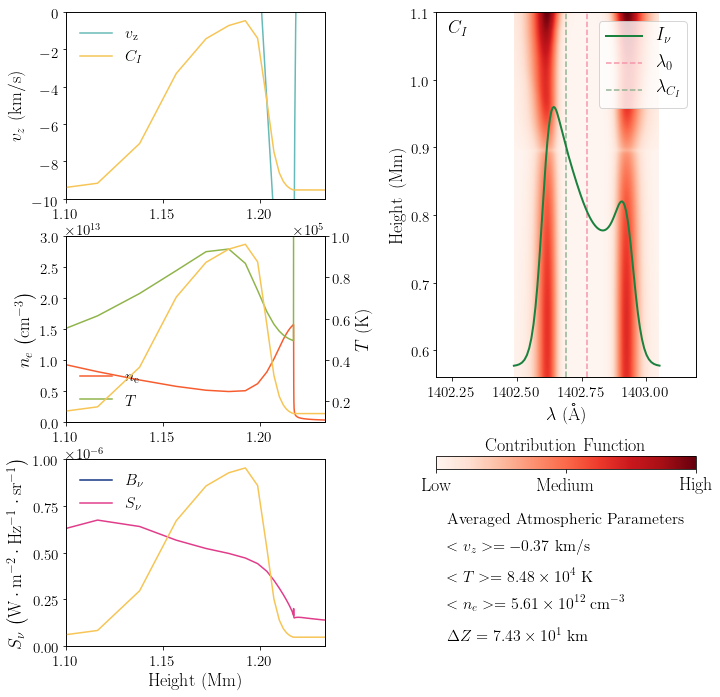

In [6]:


tindex = 25
#snapshot index(in atmosphere input file)
tindex_aux = 25
#ray angle (cosine)
mu = 0.77
#height interval
height_interval = [1.1,0.56]
height_points = np.linspace(height_interval[0],height_interval[1],100000)
#select plus wavelength in nm
wvl_plus = -0.008
#wavelength interval
wvl_wing = 0.05
#height_retention
height_ret = 0.4
#if plot density
plot_density = False
#speed of light in Km/s
c = const.c.to('km/s').value
#line core wavelength for plot
#lc_wvl = 1.e7/(71491.062-35669.312) + wvl_plus # 2791
#lc_wvl = 1.e7/35760.875 + wvl_plus #Mg II k
lc_wvl = 140.2770 + wvl_plus #Mg II h

#wavelength points in different units for plotting & interpolation
wvl_points0 = np.linspace(lc_wvl - wvl_wing,lc_wvl + wvl_wing,500)
wvl_pointsv = (wvl_points0/lc_wvl - 1)*c
wvl_pointsa = (wvl_points0 - lc_wvl) * 10
#line + continuum intensity
intensity = data.ray.intensity[tindex,0]
intensity = intensity.loc[lc_wvl - wvl_wing:lc_wvl + wvl_wing]
#intensity = intensity.interp(wavelength = wvl_points0)
#atmosphere parameters, height & temperature (dropna because of the corona cut off)
height_out = data.atmos.height_scale[tindex,0].dropna('height')/1e6
height_t_index = len(height_out)
#the height from RH1.5D outputs sometimes suffers from rounding errors
height = data_atmos['z'].value/1e6
height = np.array(height[0,tindex_aux,0,-height_t_index:])
temperature = data.atmos.temperature[tindex,0].dropna('height')
temperature.coords['height'] = height
#temperature_sel = temperature.where(temperature < 1e5,drop = True)
#temperature_sel = temperature_sel.loc[:0.5]
electron_density = data_atmos['electron_density'].value/1e6
electron_density = xr.DataArray(electron_density[0,tindex_aux,0,-height_t_index:],coords = [('height',height)]) 
if plot_density:
    density = scipy.io.readsav('/mnt/yzhu/radyn/idl/tx.sol.max5F11_d4_Ec25_Qel20s-tb09hm88.pt1s.COMPLETE.idl')['d1t']
    density = density[tindex_aux,-height_t_index:]

#electron_density_sel = electron_density.interp(height = temperature_sel.coords['height'])
#source function
sf_all = data.ray.source_function.isel(x = tindex,y = 0)
sf_drop = sf_all.dropna('height')
sf_sel = sf_drop.sel(wavelength_selected = slice(lc_wvl - wvl_wing,lc_wvl + wvl_wing))
sf_sel.coords['height'] = height
#interpolate the data to plot
sf_lc = sf_sel.sel(wavelength_selected = lc_wvl,method = 'nearest')
#Planck function at line center(stationary wavelength)
bplanck = np.array([])
bplanck = [planck(lc_wvl * u.nm,temperature_ * u.K,dist='frequency').value for temperature_ in temperature.values]
#Opacity \chi
chi_all = data.ray.chi.isel(x = tindex,y = 0)
chi_drop = chi_all.dropna('height')
chi_sel = chi_drop.sel(wavelength_selected = slice(lc_wvl - wvl_wing,lc_wvl + wvl_wing))
chi_sel.coords['height'] = height
#Optical depth \tau, integrate from \chi
tau = chi_sel[1:,:]
for i in range(len(chi_sel.coords['wavelength_selected'])):
    tau[:,i] = cumtrapz(chi_sel[:, i],x=-height*1e6)
#interpolate the data to plot
#calculate the other 3 panels
tau_exp_tau = tau * np.exp(-tau/mu)
chi_tau = chi_sel[1:,:]/tau
ctbfun = sf_sel[1:,:] * tau_exp_tau * chi_tau
ctbfun_sel = ctbfun.interp(wavelength_selected = lc_wvl)
ctbfun_pri = cumtrapz(ctbfun_sel,x = ctbfun_sel.coords['height'])
ctbfun_pri = ctbfun_pri/ctbfun_pri[-1]
ctbfun_pri = 1 - ctbfun_pri
height_cpri = interp1d(ctbfun_pri,ctbfun_sel.coords['height'][1:])([0.05,0.95])
ctbfun_plot = ctbfun.interp(height = height_points)
ctbfun_plot = ctbfun_plot.interp(wavelength_selected = wvl_points0)
ctbfun_plot = np.sqrt(ctbfun_plot)
delta_z = (height_cpri[1] -height_cpri[0])*1e3 #delta Z in km
sig_dz,exp_dz = sci_not(delta_z)
#velocity_z in km/s
velocity_z = data.atmos.velocity_z[tindex,0].dropna('height')/1e3
velocity_z.coords['height'] = height
velocity_z_sel = velocity_z.sel(height = slice(height_interval[0],height_interval[1]))
velocity_z_sel = velocity_z_sel.where(velocity_z_sel < 0,drop = True)

#Weighted average

electron_density_sel = electron_density.interp(height = np.linspace(height_cpri[1],height_cpri[0],1000))
ctbfun_sel_ne = ctbfun_sel.interp(height = electron_density_sel.coords['height'])
electron_density_aver = cumtrapz(electron_density_sel*ctbfun_sel_ne,x = -electron_density_sel.coords['height'])[-1]/cumtrapz(ctbfun_sel_ne,x = -electron_density_sel.coords['height'])[-1]
sig_eda, exp_eda = sci_not(electron_density_aver)

temperature_sel = temperature.interp(height = np.linspace(height_cpri[1],height_cpri[0],1000))
ctbfun_sel_temp = ctbfun_sel.interp(height = temperature_sel.coords['height'])
temperature_aver = cumtrapz(temperature_sel*ctbfun_sel_temp,x = -temperature_sel.coords['height'])[-1]/cumtrapz(ctbfun_sel_temp,x = -temperature_sel.coords['height'])[-1]
sig_ta, exp_ta = sci_not(temperature_aver)

ctbfun_sel_vz = ctbfun_sel.interp(height = velocity_z_sel.coords['height'])
velocity_z_aver = cumtrapz(velocity_z_sel*ctbfun_sel_vz,x = -velocity_z_sel.coords['height'])[-1]/cumtrapz(ctbfun_sel_vz,x = -velocity_z_sel.coords['height'])[-1]

#plot a figure of distribution of contribution function distribution with 
#electron density, temperature and velocity z

fig, ax = plt.subplots(figsize = (10,10))
ax11 = plt.subplot2grid((6,4),(0,0),rowspan = 2,colspan = 2)
ax12 = plt.subplot2grid((6,4),(2,0),rowspan = 2,colspan = 2)
ax15 = plt.subplot2grid((6,4),(4,0),rowspan = 2,colspan = 2)
ax21 = plt.subplot2grid((6,4),(0,2),rowspan = 5,colspan = 2)

ax12.get_shared_x_axes().join(ax12, ax11)
ax15.get_shared_x_axes().join(ax15, ax11)
#fig.suptitle(r'$\mathrm{Analysis\ of\ Mg\ II\ Contribution\ Functions\ in\ 5F11 \ Model}$',fontsize = 15)

vz, = ax11.plot(height,velocity_z,color = '#66BAB7',label = r'$v_{\mathrm{z}}$')
ax11.set_xlim(height_interval[1],height_interval[0])
ax11.set_xlim((1 + height_ret)*height_cpri[0]-height_ret*height_cpri[1],(1 + height_ret)*height_cpri[1] - height_ret*height_cpri[0])
ax11.set_ylabel(r'$v_z \ \mathrm{(km/s)}$',fontsize = 18)
ax11.set_ylim(-10,0)
ax11.xaxis.set_major_locator(ticker.MaxNLocator(3))
#ax1.subplots_adjust(right = 0.75)

ed, = ax12.plot(height,electron_density,color = '#F75C2F',label = r'$n_{\mathrm{e}}$')
ax12.set_ylabel(r'$n_e \ \mathrm{\left(cm^{-3}\right)}$',fontsize = 18)
ax12.xaxis.set_major_locator(ticker.MaxNLocator(3))
ax12.set_ylim(0,3e13)
#ax12.set_yscale('log')
#ax12.yaxis.set_major_locator(ticker.NullLocator())

ax14 = ax12.twinx()
temp, = ax14.plot(height,temperature,color = '#90B44B',label = r'$T$') 
ax14.set_ylabel(r'$T\ \mathrm{(K)}$',fontsize = 18)
ax14.set_ylim(10000,100000)
formatter = ticker.ScalarFormatter() #scientific formatting
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax14.yaxis.set_major_formatter(formatter)

bnu, = ax15.plot(height,bplanck,color = '#113285',label = r'$B_{\nu}$')
sf_nu, = ax15.plot(height,sf_lc,color = '#E03C8A',label = r'$S_{\nu}$')
ax15.yaxis.set_major_locator(ticker.NullLocator())
ax15.set_ylim(0,1e-6)
ax15.set_xlabel(r'$\mathrm{Height \ (Mm)}$',fontsize = 18)
ax15.set_ylabel(r'$S_{\nu}\ \mathrm{\left(W\cdot m^{-2}\cdot Hz^{-1}\cdot sr^{-1}\right)}$',fontsize=18)
ax15.xaxis.set_major_locator(ticker.MaxNLocator(3))
ax15.yaxis.set_major_locator(ticker.MaxNLocator(4))
ax15.yaxis.set_major_formatter(formatter)


ax11c = ax11.twinx()
ctbf1, = ax11c.plot(height[1:],ctbfun_sel,color = '#F6C555',label = r'$C_I$')
ax11c.yaxis.set_major_locator(ticker.NullLocator())

ax12c = ax12.twinx()
ctbf2, = ax12c.plot(height[1:],ctbfun_sel,color = '#F6C555',label = r'$C_I$')
ax12c.yaxis.set_major_locator(ticker.NullLocator())

ax15c = ax15.twinx()
ctbf5, = ax15c.plot(height[1:],ctbfun_sel,color = '#F6C555',label = r'$C_I$')
ax15c.yaxis.set_major_locator(ticker.NullLocator())

leg1 = [vz,ctbf1]
leg2 = [ed,temp]
leg5 = [bnu,sf_nu]

if plot_density:
    ax16 = ax11.twinx()
    den, = ax16.plot(height,density,color = '#26453D',label = r'$\rho$')
    ax16.yaxis.set_major_formatter(formatter)
    ax16.set_ylabel(r'$\rho\ \mathrm{(g\ cm^{-3})}$',fontsize=18)
    ax16.set_ylim(0,1e-8)
    leg1.append(den)
ax11.legend(leg1,[leg_.get_label() for leg_ in leg1],loc = 'upper left',fontsize = 16,frameon=False)
ax12.legend(leg2,[leg_.get_label() for leg_ in leg2],loc = 'lower left',fontsize = 16,frameon=False)
ax15.legend(leg5,[leg_.get_label() for leg_ in leg5],loc = 'upper left',fontsize = 16,frameon=False)



#ax21.imshow(ctbfun_plot,cmap = 'Reds',extent = [wvl_points0[0]*10,wvl_points0[-1]*10,height_interval[-1],height_interval[0]],aspect = 'auto')
im = ax21.imshow(ctbfun_plot,cmap = 'Reds',
                 extent = [ctbfun_plot.coords['wavelength_selected'][0]*10,ctbfun_plot.coords['wavelength_selected'][-1]*10,height_interval[-1],height_interval[0]],
                 aspect = 'auto',interpolation = 'bilinear')
#ax21.set_adjustable('box-forced')
ax21.set_title(r'$C_{I}$',x = 0.08,y = 0.92,fontsize = 18)  
ax21.set_ylabel(r'$\mathrm{Height \ \left(Mm\right)}$',fontsize = 18)
ax21.set_xlabel(r'$\lambda \ \mathrm{(\AA)}$',fontsize = 18)
ax21.yaxis.set_ticks_position('right')
ax21.xaxis.set_major_locator(ticker.AutoLocator())
swvl = ax21.axvline((lc_wvl-wvl_plus)*10,ls='--',color="#F596AA",label = r'$\lambda_{0}$')
cwvl = ax21.axvline(lc_wvl*10,ls='--',color = '#91B493',label = r'$\lambda_{C_I}$')
ax21.set_xlim(ctbfun_plot.coords['wavelength_selected'][0]*10,ctbfun_plot.coords['wavelength_selected'][-1]*10)


ax22 = ax21.twinx()
inten, = ax22.plot(intensity.coords['wavelength']*10,intensity,color = '#1B813E',label = r'$I_{\nu}$',linewidth=2)
ax22.yaxis.set_major_locator(ticker.NullLocator())
ax22.set_ylim(ax22.get_ylim()[0]*0.9,ax22.get_ylim()[1]*1.3)

leg = [inten,swvl,cwvl]
ax22.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper right',fontsize = 18)
fig.text(0.63,0.13,r'$ \displaystyle <n_e> = %s\times10^{%s} \ \mathrm{cm}^{-3}$' %(sig_eda,exp_eda),fontsize=16) 
fig.text(0.63,0.17,r'$ \displaystyle <T> = %s\times10^{%s} \ \mathrm{K}$'  %(sig_ta,exp_ta),fontsize=16) 
fig.text(0.63,0.21,r'$ \displaystyle <v_z> = %4.2f \ \mathrm{km/s}$' %(velocity_z_aver),fontsize = 16)
fig.text(0.63,0.09,r'$\Delta Z = %s\times10^{%s} \ \mathrm{km}$'%(sig_dz,exp_dz),fontsize = 16)
fig.text(0.63,0.25,r'$\mathrm{Averaged\ Atmospheric\ Parameters}$',fontsize = 16)
rcParams.update({'mathtext.fontset':'stix'})

for ax_ in [ax11,ax12,ax14,ax15,ax21]:
    ax_.tick_params(labelsize=15)
    ax_.yaxis.get_offset_text().set_fontsize(15)
clb = plt.colorbar(im,pad = 0.15,orientation='horizontal',ticks=[0,ctbfun_plot.max()/2,ctbfun_plot.max()])
clb.ax.set_title(r'$\mathrm{Contribution\ Function}$',fontsize=18)
clb.ax.set_xticklabels([r'$\mathrm{Low}$',r'$\mathrm{Medium}$',r'$\mathrm{High}$'],fontsize=18)
plt.subplots_adjust(bottom = 0.08,left=0.1,top=0.96,right=0.975,wspace = 1.5,hspace=0.5)
#plt.savefig(fname = 'figs/eps/ctb_5F11_250_lc_paper.eps', dpi = 300, format = 'eps')
#plt.savefig(fname = 'figs/png/ctb_5F11_250_lc_paper.png', dpi = 600, format = 'png')

/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


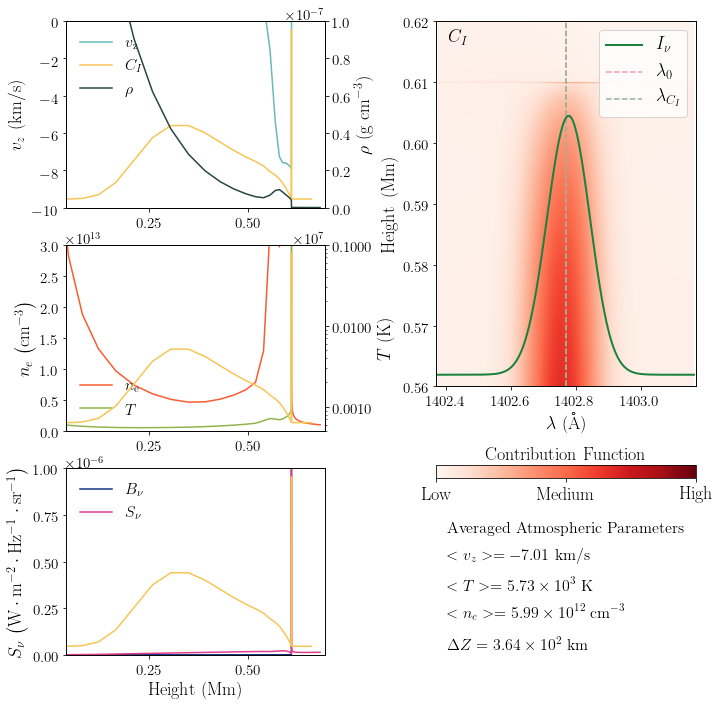

In [5]:


tindex = 210
#snapshot index(in atmosphere input file)
tindex_aux = 210
#ray angle (cosine)
mu = 0.77
#height interval
height_interval = [0.62,0.56]
height_points = np.linspace(height_interval[0],height_interval[1],100000)
#select plus wavelength in nm
wvl_plus = 0
#wavelength interval
wvl_wing = 0.04
#height_retention
height_ret = 0.4
#if plot density
plot_density = True
#speed of light in Km/s
c = const.c.to('km/s').value
#line core wavelength for plot
#lc_wvl = 1.e7/(71491.062-35669.312) + wvl_plus # 2791
#lc_wvl = 1.e7/35760.875 + wvl_plus #Mg II k
lc_wvl = 140.2770 + wvl_plus #Mg II h

#wavelength points in different units for plotting & interpolation
wvl_points0 = np.linspace(lc_wvl - wvl_wing,lc_wvl + wvl_wing,500)
wvl_pointsv = (wvl_points0/lc_wvl - 1)*c
wvl_pointsa = (wvl_points0 - lc_wvl) * 10
#line + continuum intensity
intensity = data.ray.intensity[tindex,0]
intensity = intensity.loc[lc_wvl - wvl_wing:lc_wvl + wvl_wing]
#intensity = intensity.interp(wavelength = wvl_points0)
#atmosphere parameters, height & temperature (dropna because of the corona cut off)
height_out = data.atmos.height_scale[tindex,0].dropna('height')/1e6
height_t_index = len(height_out)
#the height from RH1.5D outputs sometimes suffers from rounding errors
height = data_atmos['z'].value/1e6
height = np.array(height[0,tindex_aux,0,-height_t_index:])
temperature = data.atmos.temperature[tindex,0].dropna('height')
temperature.coords['height'] = height
#temperature_sel = temperature.where(temperature < 1e5,drop = True)
#temperature_sel = temperature_sel.loc[:0.5]
electron_density = data_atmos['electron_density'].value/1e6
electron_density = xr.DataArray(electron_density[0,tindex_aux,0,-height_t_index:],coords = [('height',height)]) 
if plot_density:
    density = scipy.io.readsav('/Volumes/yjzhu/radyn/idl/tx.sol.max5F11_d4_Ec25_Qel20s-tb09hm88.pt1s.COMPLETE.idl')['d1t']
    density = density[tindex_aux,-height_t_index:]

#electron_density_sel = electron_density.interp(height = temperature_sel.coords['height'])
#source function
sf_all = data.ray.source_function.isel(x = tindex,y = 0)
sf_drop = sf_all.dropna('height')
sf_sel = sf_drop.sel(wavelength_selected = slice(lc_wvl - wvl_wing,lc_wvl + wvl_wing))
sf_sel.coords['height'] = height
#interpolate the data to plot
sf_lc = sf_sel.sel(wavelength_selected = lc_wvl,method = 'nearest')
#Planck function at line center(stationary wavelength)
bplanck = np.array([])
bplanck = [planck(lc_wvl * u.nm,temperature_ * u.K,dist='frequency').value for temperature_ in temperature.values]
#Opacity \chi
chi_all = data.ray.chi.isel(x = tindex,y = 0)
chi_drop = chi_all.dropna('height')
chi_sel = chi_drop.sel(wavelength_selected = slice(lc_wvl - wvl_wing,lc_wvl + wvl_wing))
chi_sel.coords['height'] = height
#Optical depth \tau, integrate from \chi
tau = chi_sel[1:,:]
for i in range(len(chi_sel.coords['wavelength_selected'])):
    tau[:,i] = cumtrapz(chi_sel[:, i],x=-height*1e6)
#interpolate the data to plot
#calculate the other 3 panels
tau_exp_tau = tau * np.exp(-tau/mu)
chi_tau = chi_sel[1:,:]/tau
ctbfun = sf_sel[1:,:] * tau_exp_tau * chi_tau
ctbfun_sel = ctbfun.interp(wavelength_selected = lc_wvl)
ctbfun_pri = cumtrapz(ctbfun_sel,x = ctbfun_sel.coords['height'])
ctbfun_pri = ctbfun_pri/ctbfun_pri[-1]
ctbfun_pri = 1 - ctbfun_pri
height_cpri = interp1d(ctbfun_pri,ctbfun_sel.coords['height'][1:])([0.05,0.95])
#height_cpri = np.array([0.609,0.611])
ctbfun_plot = ctbfun.interp(height = height_points)
ctbfun_plot = ctbfun_plot.interp(wavelength_selected = wvl_points0)
ctbfun_plot = np.sqrt(ctbfun_plot)
delta_z = (height_cpri[1] -height_cpri[0])*1e3 #delta Z in km
sig_dz,exp_dz = sci_not(delta_z)
#velocity_z in km/s
velocity_z = data.atmos.velocity_z[tindex,0].dropna('height')/1e3
velocity_z.coords['height'] = height
velocity_z_sel = velocity_z.sel(height = slice(height_interval[0],height_interval[1]))
velocity_z_sel = velocity_z_sel.where(velocity_z_sel < 0,drop = True)

#Weighted average

electron_density_sel = electron_density.interp(height = np.linspace(height_cpri[1],height_cpri[0],1000))
ctbfun_sel_ne = ctbfun_sel.interp(height = electron_density_sel.coords['height'])
electron_density_aver = cumtrapz(electron_density_sel*ctbfun_sel_ne,x = -electron_density_sel.coords['height'])[-1]/cumtrapz(ctbfun_sel_ne,x = -electron_density_sel.coords['height'])[-1]
sig_eda, exp_eda = sci_not(electron_density_aver)

temperature_sel = temperature.interp(height = np.linspace(height_cpri[1],height_cpri[0],1000))
ctbfun_sel_temp = ctbfun_sel.interp(height = temperature_sel.coords['height'])
temperature_aver = cumtrapz(temperature_sel*ctbfun_sel_temp,x = -temperature_sel.coords['height'])[-1]/cumtrapz(ctbfun_sel_temp,x = -temperature_sel.coords['height'])[-1]
sig_ta, exp_ta = sci_not(temperature_aver)

ctbfun_sel_vz = ctbfun_sel.interp(height = velocity_z_sel.coords['height'])
velocity_z_aver = cumtrapz(velocity_z_sel*ctbfun_sel_vz,x = -velocity_z_sel.coords['height'])[-1]/cumtrapz(ctbfun_sel_vz,x = -velocity_z_sel.coords['height'])[-1]

#plot a figure of distribution of contribution function distribution with 
#electron density, temperature and velocity z

fig, ax = plt.subplots(figsize = (10,10))
ax11 = plt.subplot2grid((6,4),(0,0),rowspan = 2,colspan = 2)
ax12 = plt.subplot2grid((6,4),(2,0),rowspan = 2,colspan = 2)
ax15 = plt.subplot2grid((6,4),(4,0),rowspan = 2,colspan = 2)
ax21 = plt.subplot2grid((6,4),(0,2),rowspan = 5,colspan = 2)

ax12.get_shared_x_axes().join(ax12, ax11)
ax15.get_shared_x_axes().join(ax15, ax11)
#fig.suptitle(r'$\mathrm{Analysis\ of\ Mg\ II\ Contribution\ Functions\ in\ 5F11 \ Model}$',fontsize = 15)

vz, = ax11.plot(height,velocity_z,color = '#66BAB7',label = r'$v_{\mathrm{z}}$')
ax11.set_xlim(height_interval[1],height_interval[0])
ax11.set_xlim((1 + height_ret)*height_cpri[0]-height_ret*height_cpri[1],(1 + height_ret)*height_cpri[1] - height_ret*height_cpri[0])
ax11.set_ylabel(r'$v_z \ \mathrm{(km/s)}$',fontsize = 18)
ax11.set_ylim(-10,0)
ax11.xaxis.set_major_locator(ticker.MaxNLocator(3))
#ax1.subplots_adjust(right = 0.75)

ed, = ax12.plot(height,electron_density,color = '#F75C2F',label = r'$n_{\mathrm{e}}$')
ax12.set_ylabel(r'$n_e \ \mathrm{\left(cm^{-3}\right)}$',fontsize = 18)
ax12.xaxis.set_major_locator(ticker.MaxNLocator(3))
ax12.set_ylim(0,3e13)
#ax12.set_yscale('log')
#ax12.yaxis.set_major_locator(ticker.NullLocator())

ax14 = ax12.twinx()
temp, = ax14.plot(height,temperature,color = '#90B44B',label = r'$T$') 
ax14.set_ylabel(r'$T\ \mathrm{(K)}$',fontsize = 18)
ax14.set_ylim(5000.,1.0e6)
ax14.set_yscale('log')
formatter = ticker.ScalarFormatter() #scientific formatting
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
ax14.yaxis.set_major_formatter(formatter)

bnu, = ax15.plot(height,bplanck,color = '#113285',label = r'$B_{\nu}$')
sf_nu, = ax15.plot(height,sf_lc,color = '#E03C8A',label = r'$S_{\nu}$')
ax15.yaxis.set_major_locator(ticker.NullLocator())
ax15.set_ylim(0,1e-6)
ax15.set_xlabel(r'$\mathrm{Height \ (Mm)}$',fontsize = 18)
ax15.set_ylabel(r'$S_{\nu}\ \mathrm{\left(W\cdot m^{-2}\cdot Hz^{-1}\cdot sr^{-1}\right)}$',fontsize=18)
ax15.xaxis.set_major_locator(ticker.MaxNLocator(3))
ax15.yaxis.set_major_locator(ticker.MaxNLocator(4))
ax15.yaxis.set_major_formatter(formatter)


ax11c = ax11.twinx()
ctbf1, = ax11c.plot(height[1:],ctbfun_sel,color = '#F6C555',label = r'$C_I$')
ax11c.yaxis.set_major_locator(ticker.NullLocator())

ax12c = ax12.twinx()
ctbf2, = ax12c.plot(height[1:],ctbfun_sel,color = '#F6C555',label = r'$C_I$')
ax12c.yaxis.set_major_locator(ticker.NullLocator())

ax15c = ax15.twinx()
ctbf5, = ax15c.plot(height[1:],ctbfun_sel,color = '#F6C555',label = r'$C_I$')
ax15c.yaxis.set_major_locator(ticker.NullLocator())

leg1 = [vz,ctbf1]
leg2 = [ed,temp]
leg5 = [bnu,sf_nu]

if plot_density:
    ax16 = ax11.twinx()
    den, = ax16.plot(height,density,color = '#26453D',label = r'$\rho$')
    ax16.yaxis.set_major_formatter(formatter)
    ax16.set_ylabel(r'$\rho\ \mathrm{(g\ cm^{-3})}$',fontsize=18)
    ax16.set_ylim(0,1e-7)
    leg1.append(den)
ax11.legend(leg1,[leg_.get_label() for leg_ in leg1],loc = 'upper left',fontsize = 16,frameon=False)
ax12.legend(leg2,[leg_.get_label() for leg_ in leg2],loc = 'lower left',fontsize = 16,frameon=False)
ax15.legend(leg5,[leg_.get_label() for leg_ in leg5],loc = 'upper left',fontsize = 16,frameon=False)



#ax21.imshow(ctbfun_plot,cmap = 'Reds',extent = [wvl_points0[0]*10,wvl_points0[-1]*10,height_interval[-1],height_interval[0]],aspect = 'auto')
im = ax21.imshow(ctbfun_plot,cmap = 'Reds',
                 extent = [ctbfun_plot.coords['wavelength_selected'][0]*10,ctbfun_plot.coords['wavelength_selected'][-1]*10,height_interval[-1],height_interval[0]],
                 aspect = 'auto',interpolation = 'bilinear',vmin=0)
#ax21.set_adjustable('box-forced')
ax21.set_title(r'$C_{I}$',x = 0.08,y = 0.92,fontsize = 18)  
ax21.set_ylabel(r'$\mathrm{Height \ \left(Mm\right)}$',fontsize = 18)
ax21.set_xlabel(r'$\lambda \ \mathrm{(\AA)}$',fontsize = 18)
ax21.yaxis.set_ticks_position('right')
ax21.xaxis.set_major_locator(ticker.AutoLocator())
swvl = ax21.axvline((lc_wvl-wvl_plus)*10,ls='--',color="#F596AA",label = r'$\lambda_{0}$')
cwvl = ax21.axvline(lc_wvl*10,ls='--',color = '#91B493',label = r'$\lambda_{C_I}$')
ax21.set_xlim(ctbfun_plot.coords['wavelength_selected'][0]*10,ctbfun_plot.coords['wavelength_selected'][-1]*10)


ax22 = ax21.twinx()
inten, = ax22.plot(intensity.coords['wavelength']*10,intensity,color = '#1B813E',label = r'$I_{\nu}$',linewidth=2)
ax22.yaxis.set_major_locator(ticker.NullLocator())
ax22.set_ylim(ax22.get_ylim()[0]*0.9,ax22.get_ylim()[1]*1.3)

leg = [inten,swvl,cwvl]
ax22.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper right',fontsize = 18)
fig.text(0.63,0.13,r'$ \displaystyle <n_e> = %s\times10^{%s} \ \mathrm{cm}^{-3}$' %(sig_eda,exp_eda),fontsize=16) 
fig.text(0.63,0.17,r'$ \displaystyle <T> = %s\times10^{%s} \ \mathrm{K}$'  %(sig_ta,exp_ta),fontsize=16) 
fig.text(0.63,0.21,r'$ \displaystyle <v_z> = %4.2f \ \mathrm{km/s}$' %(velocity_z_aver),fontsize = 16)
fig.text(0.63,0.09,r'$\Delta Z = %s\times10^{%s} \ \mathrm{km}$'%(sig_dz,exp_dz),fontsize = 16)
fig.text(0.63,0.25,r'$\mathrm{Averaged\ Atmospheric\ Parameters}$',fontsize = 16)
rcParams.update({'mathtext.fontset':'stix'})

for ax_ in [ax11,ax12,ax14,ax15,ax21,ax16]:
    ax_.tick_params(labelsize=15)
    ax_.yaxis.get_offset_text().set_fontsize(15)
clb = plt.colorbar(im,pad = 0.15,orientation='horizontal',ticks=[0,ctbfun_plot.max()/2,ctbfun_plot.max()])
clb.ax.set_title(r'$\mathrm{Contribution\ Function}$',fontsize=18)
clb.ax.set_xticklabels([r'$\mathrm{Low}$',r'$\mathrm{Medium}$',r'$\mathrm{High}$'],fontsize=18)
plt.subplots_adjust(bottom = 0.08,left=0.1,top=0.96,right=0.975,wspace = 1.5,hspace=0.5)
plt.savefig(fname = '../figs/ctb_5F11_SiIV_210.eps', dpi = 300, format = 'eps')
plt.savefig(fname = '../figs/png/ctb_5F11_SiIV_210.png', dpi = 600, format = 'png')

In [7]:
print(data.ray.source_function.coords['wavelength_selected'].values)

[140.20200554 140.2054582  140.20873923 140.2118573  140.21482066
 140.21763712 140.22031412 140.2228587  140.22527756 140.22757705
 140.22976322 140.23184178 140.23381818 140.23569759 140.2374849
 140.23918478 140.24080165 140.24233969 140.24380291 140.24519507
 140.24651978 140.24778043 140.24898028 140.2501224  140.2512097
 140.25224496 140.2532308  140.25416973 140.25506411 140.25591621
 140.25672815 140.25750197 140.25823959 140.25894285 140.25961348
 140.26025313 140.26086338 140.26144569 140.26200149 140.26253212
 140.26303885 140.26352289 140.26398538 140.26442742 140.26485004
 140.26525422 140.26564089 140.26601094 140.26636521 140.26670449
 140.26702955 140.2673411  140.26763983 140.26792638 140.26820138
 140.26846539 140.26871899 140.26896269 140.269197   140.26942239
 140.26963932 140.2698482  140.27004945 140.27024345 140.27043057
 140.27061116 140.27078555 140.27095405 140.27111695 140.27127455
 140.27142711 140.27157488 140.27171811 140.27185702 140.27199184
 140.2721227